# Importing Libraries

In [2]:
import torch
import torchvision
import torch.nn as nn 
from torchvision.transforms import transforms
import glob
import cv2
import copy
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Hyperparameters

In [12]:
num_epochs = 12
lr = 0.01
batch_size = 4

# Downloading the CIFAR-10 Dataset

In [13]:
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

In [14]:
my_transform = transforms.ToTensor()
train_dataset = torchvision.datasets.CIFAR10(root='./cifar', train=True, download=True, transform=data_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./cifar', train = False, transform=data_transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
n_samples = len(train_dataset)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77254903..1.0].


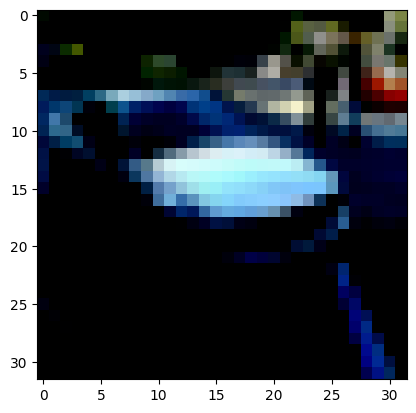

In [15]:
train_iter = iter(train_loader)
item, label = train_iter._next_data()
npimg = np.transpose(item[1].numpy(), (1, 2, 0))
plt.imshow(npimg)

# Data Preprocessing

In [16]:
class DataSet(torchvision.datasets.CIFAR10):
    def __init__(self, root, train, n_channels = 3, mask_iterations = 5, image_dim = (32,32), download=True):
        super().__init__(root, train, download=download)
        self.img_dim = image_dim
        self.to_tensor = transforms.ToTensor()
        self.channels = n_channels
        self.iterations = mask_iterations
        self.resize = transforms.Resize(image_dim)
    
    
    def line_generator(self, image):
        for _ in range(self.iterations):
            pt1 = (np.random.randint(0,self.img_dim[0]),np.random.randint(0,self.img_dim[1]))
            pt2 = (np.random.randint(0,self.img_dim[0]),np.random.randint(0,self.img_dim[1]))
            thickness =np.random.randint(1, 3)
            
            cv2.line(image, pt1=pt1, pt2=pt2, color=(1,1,1), thickness=thickness)

    def circle_generator(self, image):
        for _ in range(self.iterations):
            pt1 = (np.random.randint(0,self.img_dim[0]),np.random.randint(0,self.img_dim[1]))
            radius =np.random.randint(1, 3)

            cv2.circle(image,pt1,radius,(1,1,1), -1)

    def create_mask(self, image):
        mask = np.full((self.img_dim[0], self.img_dim[1], self.channels), 255, dtype=np.uint8)
        self.line_generator(mask)
        self.circle_generator(mask)

        image = np.asarray(image)
        masked_image = cv2.bitwise_and(image, mask)
        return masked_image, mask
    
    def __getitem__(self, index):
        # Since this is not classification, we can ignore the labels
        image, _ = super().__getitem__(index)
        Y_output = self.resize(image)

        X_input, X_mask = self.create_mask(Y_output)
        X_input = self.to_tensor(X_input)
        X_mask = self.to_tensor(X_mask)
        Y_output = self.to_tensor(Y_output)
        return X_input, X_mask, Y_output



In [17]:
Training_Data = DataSet(root='./cifar', train=True)
Testing_Data = DataSet(root='./cifar', train=False)

Training_Loader = torch.utils.data.DataLoader(Training_Data, batch_size, shuffle=True)
Testing_Loader = torch.utils.data.DataLoader(Testing_Data, batch_size, shuffle=False)

Train_Iter = iter(Training_Loader)
Test_Iter = iter(Testing_Loader)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([4, 3, 32, 32]) torch.Size([4, 3, 32, 32]) torch.Size([4, 3, 32, 32])
Masked Image


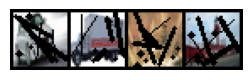

Masking Pattern


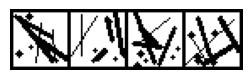

Original Image


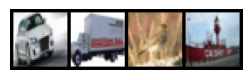

In [9]:
X_in, X_mask, Y_out = Train_Iter._next_data()
print(X_in.shape, X_mask.shape, Y_out.shape)

def imshow_masked(img):
  npimg = img.numpy()
  plt.figure(figsize = (3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

print('Masked Image')
imshow_masked(torchvision.utils.make_grid(X_in))
print('Masking Pattern')
imshow_masked(torchvision.utils.make_grid(X_mask))
print('Original Image')
imshow_masked(torchvision.utils.make_grid(Y_out))

# Random mask generator

In [10]:
def line_generator(image, iterations, height, width):
    for i in range(iterations):
        pt1 = (np.random.randint(0,height),np.random.randint(0,width))
        pt2 = (np.random.randint(0,height),np.random.randint(0,width))
        thickness =np.random.randint(5, 20)
        
        cv2.line(image, pt1=pt1, pt2=pt2, color=(1,1,1), thickness=thickness)

def circle_generator(image, iterations, height, width):
    for i in range(iterations):
        pt1 = (np.random.randint(0,height),np.random.randint(0,width))
        radius =np.random.randint(5, 20)

        cv2.circle(image,pt1,radius,(1,1,1), -1)

# Creating the model using custom layers

![Network Architecture](CIFAR_10_Network_Architecture.PNG)

In [6]:
class Partial_Conv(nn.Module):
    def __init__(self, input_filters, output_filters, kernel_size=(3,3), padding=0, stride=1, bias=True, groups=1,dilation=1):
        super().__init__()
        padding = (kernel_size[0]//2, kernel_size[1]//2)
        self.input_conv = nn.Conv2d(input_filters,output_filters,kernel_size,stride,padding,dilation,groups,bias)
        self.mask_conv = nn.Conv2d(input_filters,output_filters,kernel_size,stride,padding,dilation,groups, False)

        self.window_size = kernel_size[0]*kernel_size[1]
        nn.init.constant_(self.mask_conv.weight, 1.0)

        for param in self.mask_conv.parameters():
            param.requires_grad = False
    
    def forward(self, input, mask):
        output = self.input_conv(input * mask)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        mask_ratio = self.window_size / (output_mask + 1e-8)
        output_mask = torch.clamp(output_mask, 0, 1)
        mask_ratio = mask_ratio * output_mask
        output = output * mask_ratio

        return output, output_mask


In [7]:
class EncoderLayer(nn.Module):
    def __init__(self, in_filters, output_filters):
        super().__init__()
        self.in_filters = in_filters
        self.out_filters = output_filters
        self.conv_1 = Partial_Conv(self.in_filters, self.out_filters, stride=1)
        self.act_1 = nn.ReLU()
        self.conv_2 = Partial_Conv(self.out_filters, self.out_filters, stride=2)
        self.act_2 = nn.ReLU()

    def forward(self, inputs, masks):
        conv_out_1, mask_out_1 = self.conv_1(inputs, masks)
        conv_out_1 = self.act_1(conv_out_1)
        conv_out_2, mask_out_2 = self.conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(conv_out_2)
        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [8]:
class DecoderLayer(nn.Module):
    def __init__(self, in_filters, out_filters):
        super().__init__()
        self.in_filters = in_filters
        self.out_filters = out_filters
        self.up_image = nn.Upsample(scale_factor=(2,2))
        self.up_mask = nn.Upsample(scale_factor=(2,2))

        self.conv_1 = Partial_Conv(self.in_filters*2, self.in_filters)
        self.act_1 = nn.LeakyReLU(negative_slope=0.2)
        self.conv_2 = Partial_Conv(self.in_filters, self.out_filters)
        self.act_2 = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, input_image, input_mask, shared_image, shared_mask):
        up_image, up_mask = self.up_image(input_image), self.up_mask(input_mask)

        concat_image = torch.cat((shared_image, up_image), axis=1)
        concat_mask = torch.cat((shared_mask, up_mask), axis=1)

        conv_out_1, mask_out_1 = self.conv_1(concat_image, concat_mask)
        conv_out_1 = self.act_1(conv_out_1)
        conv_out_2, mask_out_2 = self.conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(conv_out_2)
        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [9]:
class InpaintingModel(nn.Module):
    def __init__(self, num_channels=3):
        super().__init__()
        self.encoder_1 = EncoderLayer(num_channels, 32)
        self.encoder_2 = EncoderLayer(32, 64)
        self.encoder_3 = EncoderLayer(64, 128)
        self.encoder_4 = EncoderLayer(128, 256)

        self.decoder_1 = DecoderLayer(256, 128)
        self.decoder_2 = DecoderLayer(128, 64)
        self.decoder_3 = DecoderLayer(64, 32)
        self.decoder_4 = DecoderLayer(32, 3)

        self.output_layer = nn.Sequential(
            nn.Conv2d(3, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )

    def forward(self, inputs, masks):
        #input: 32*32 with 3 channels
        conv_1, mask_1, conv_2, mask_2 = self.encoder_1(inputs, masks)
        #conv_1: 32*32 with 32 ch. conv_2: 16*16 with 32 ch.
        conv_3, mask_3, conv_4, mask_4 = self.encoder_2(conv_2, mask_2)
        #conv_3: 16*16 with 64 ch. conv_4: 8*8 with 64 ch.
        conv_5, mask_5, conv_6, mask_6 = self.encoder_3(conv_4, mask_4)
        #conv_5: 8*8 with 128 ch. conv_6: 4*4 with 128 ch.
        conv_7, mask_7, conv_8, mask_8 = self.encoder_4(conv_6, mask_6)
        #conv_7: 4*4 with 256 ch. conv_8: 2*2 with 256 ch.

        conv_9, mask_9, conv_10, mask_10 = self.decoder_1(conv_8, mask_8, conv_7, mask_7)
        #conv_9: 4*4 with 256 ch. #conv_10: 4*4 with 128 ch.
        conv_11, mask_11, conv_12, mask_12 = self.decoder_2(conv_10, mask_10, conv_5, mask_5)
        #conv_11: 8*8 with 128 ch. #conv_12: 8*8 with 64 ch.
        conv_13, mask_13, conv_14, mask_14 = self.decoder_3(conv_12, mask_12, conv_3, mask_3)
        #conv_13: 16*16 with 64 ch. #conv_14: 16*16 with 32 ch.
        conv_15, mask_15, conv_16, mask_16 = self.decoder_4(conv_14, mask_14, conv_1, mask_1)
        #conv_15: 32*32 with 32 ch. #conv_16: 32*32 with 3 ch.

        outputs = self.output_layer(conv_16)
        return outputs



In [15]:

model = InpaintingModel().to(device=device)

Min loss: 0.0415
Iteration 0/12500.0, Loss: 0.0415
Min loss: 0.0393
Min loss: 0.0353
Min loss: 0.0251
Iteration 100/12500.0, Loss: 0.0557
Iteration 200/12500.0, Loss: 0.0305
Iteration 300/12500.0, Loss: 0.0394
Min loss: 0.0241
Min loss: 0.0222
Min loss: 0.0196
Iteration 400/12500.0, Loss: 0.0499
Min loss: 0.0150
Iteration 500/12500.0, Loss: 0.0303
Min loss: 0.0118
Min loss: 0.0116
Iteration 600/12500.0, Loss: 0.0209
Min loss: 0.0102
Iteration 700/12500.0, Loss: 0.0198
Iteration 800/12500.0, Loss: 0.0159
Min loss: 0.0101
Min loss: 0.0097
Min loss: 0.0091
Min loss: 0.0086
Min loss: 0.0083
Iteration 900/12500.0, Loss: 0.0184
Iteration 1000/12500.0, Loss: 0.0152
Min loss: 0.0073
Iteration 1100/12500.0, Loss: 0.0140
Iteration 1200/12500.0, Loss: 0.0128
Min loss: 0.0064
Iteration 1300/12500.0, Loss: 0.0153
Iteration 1400/12500.0, Loss: 0.0110
Iteration 1500/12500.0, Loss: 0.0105
Iteration 1600/12500.0, Loss: 0.0106
Min loss: 0.0059
Iteration 1700/12500.0, Loss: 0.0102
Min loss: 0.0054
Min lo

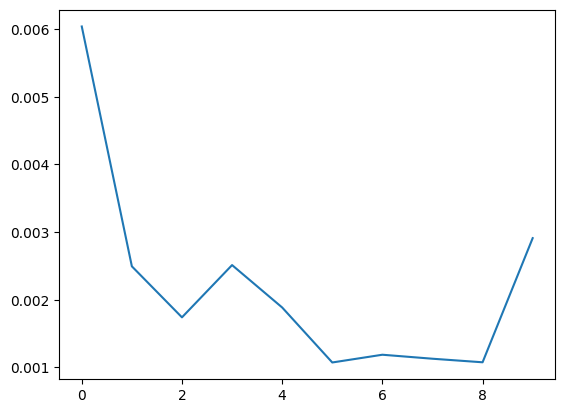

In [16]:
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters())

loss_epoch_arr = []
max_epochs = 10
min_loss = 1000
n_iters = np.ceil(len(Training_Loader))
for epoch in range(max_epochs):
    model.train()
    for i, (x_input, x_mask, y_output) in enumerate(Training_Loader):
        x_input, x_mask, y_output = x_input.to(device), x_mask.to(device), y_output.to(device)
        opt.zero_grad()

        outputs = model(x_input, x_mask)
        loss = loss_fn(y_output, outputs)
        loss.backward()
        opt.step()

        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            print(f'Min loss: {min_loss:.4f}')

        if not i%100:
            print(f'Iteration {i}/{n_iters}, Loss: {loss.item():.4f}')
        
    loss_epoch_arr.append(loss.item())

plt.plot(loss_epoch_arr)
plt.show()

# Testing sample examples

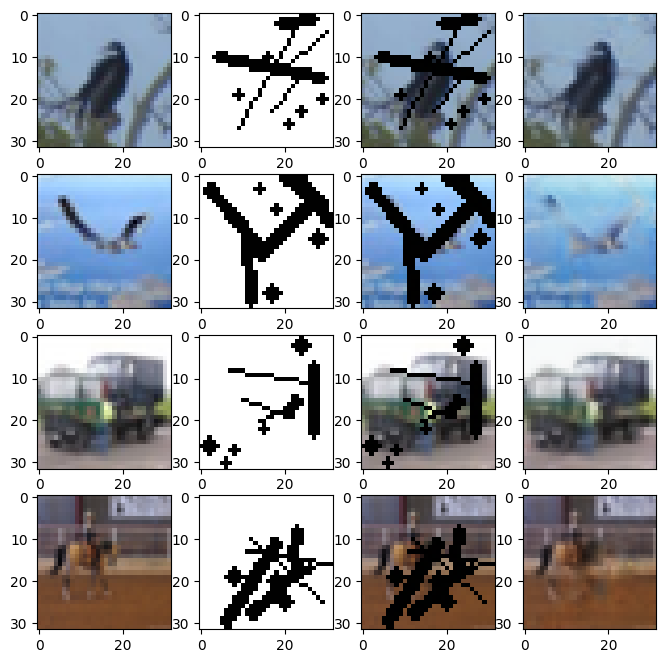

In [23]:
import pickle
filename = "32resoModel"

model.load_state_dict(best_model)
pickle.dump(model, open(filename, 'wb'))
sample_inputs, sample_masks, sample_truths = Train_Iter._next_data()
sample_inputs, sample_masks = sample_inputs.to(device), sample_masks.to(device)

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))

# Saving the model to a file and testing the loading

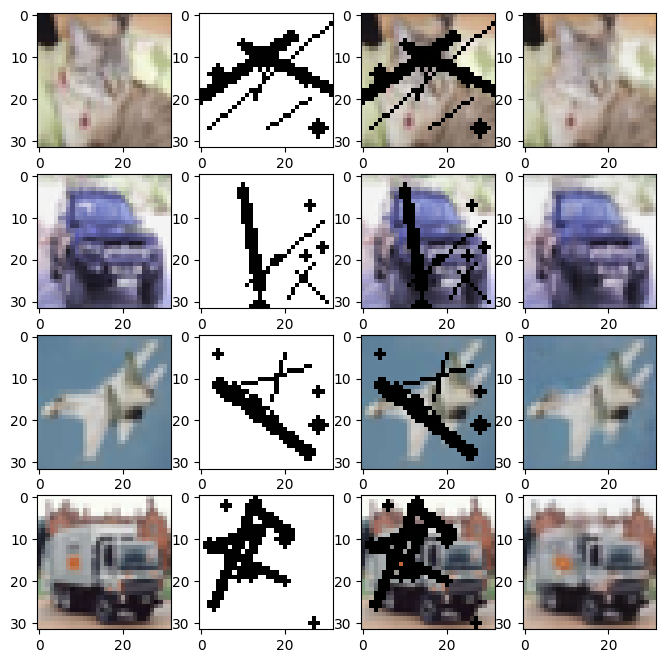

In [20]:
import pickle
filename = '32reso-best'

loaded_model = pickle.load(open(filename, 'rb'))
sample_inputs, sample_masks, sample_truths = Test_Iter._next_data()
sample_inputs, sample_masks = sample_inputs.to(device), sample_masks.to(device)


with torch.no_grad():
    sample_preds = loaded_model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))
